# **Import Statements:**

In [37]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/CS196Project/Group6/finetuning"

!pip install pyarrow==2.0.0
!pip install -r requirements.txt

import torch
from datasets import load_dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS196Project/Group6/finetuning


Get all required code for finetuning.

In [ ]:
%%bash
cd "/content/drive/My Drive/CS196Project/Group6/finetuning/seq2seq"

# These files are already stored in our GitHub Repo

# wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/seq2seq/finetune.py
# wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/seq2seq/callbacks.py
# wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/seq2seq/utils.py
# wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/seq2seq/sentence_splitter.py
# wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/lightning_base.py
# wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/requirements.txt

# **Load Datasets:**

 TODO: format newsroom


In [ ]:
# newsroom = load_dataset('newsroom', data_dir='/content/drive/My Drive/CS196Project/newsroom')

Create Custom Dataset:

In [ ]:
import re

class CreateDataset:
  def __init__(self, folder_path: str, split_ratio=(2, 1, 1)):
    assert len(split_ratio) == 3
    assert type(split_ratio) == tuple
    # split_ratio = (train, test, val)

    assert type(folder_path) == str
    assert folder_path != None and len(folder_path) > 0

    if folder_path[:-1] != "/":
      folder_path += "/"

    self.iter_counter = 0
    self.split_counter = 0
    self.train_cut = split_ratio[0]
    self.test_cut = self.train_cut + split_ratio[1]
    self.val_cut = self.test_cut + split_ratio[2]

    train_source = open("{}train.source".format(folder_path), "w+")
    train_target = open("{}train.target".format(folder_path), "w+")
    test_source = open("{}test.source".format(folder_path), "w+")
    test_target = open("{}test.target".format(folder_path), "w+")
    val_source = open("{}val.source".format(folder_path), "w+")
    val_target = open("{}val.target".format(folder_path), "w+")

    self.sources = [train_source, test_source, val_source]
    self.targets = [train_target, test_target, val_target]

    self.source_lengths = []
    self.target_lengths = []

  def create_data_files(self, data_path: str, finished=False) -> None:
    assert type(data_path) == str
    assert data_path != None and len(data_path) > 0

    lines = self._get_prepared_lines(data_path)

    for example in lines:
      if not len(example):  # ignore any emtpy text
        continue
      
      source, target = self._next_entry()

      data = example.replace("[SEP]", "")
      text, summary = data.split("[SUMM]")

      self.source_lengths.append(len(text.split(" ")))
      self.target_lengths.append(len(summary.split(" ")))

      source.write("{}\n".format(text))
      target.write("{}\n".format(summary))

    if finished:
      self._finish()

  def _get_prepared_lines(self, data_path: str) -> list:
    text_file = open(data_path, "r").read()
    text_file = text_file.replace("\n", " ")
    text_file = text_file.replace("\t", " ")
    # strip text of all newlines, so we can control where they get places later on
    # newlines are used to separate entries in train/test/validation datasets
    
    text_file = re.sub(r' [ ]+', ' ', text_file)
    # Replace any sequences of 2+ spaces with a single space

    # text_file = re.sub(r'\.(?=[^ ])', '. ', text_file)
    # replace a period followed immediately with a character with a period and a space

    split_by_separation = text_file.split("[TEXT]")
    
    return split_by_separation

  def _finish(self) -> None:
    for f in self.sources:
      f.close()
    
    for f in self.targets:
      f.close()
      
  def _next_entry(self) -> tuple:
    if self.iter_counter == self.val_cut:
      self.split_counter = 0
      self.iter_counter = 0
    elif self.iter_counter == self.train_cut or self.iter_counter == self.test_cut:
      self.split_counter += 1
      
    self.iter_counter += 1
    return self.sources[self.split_counter], self.targets[self.split_counter]

Create the text training, testing, and validation files.

In [ ]:
%cd "/content/drive/My Drive/CS196Project/Group6/finetuning/"

dataset = CreateDataset("lecture_transcripts/")
dataset.create_data_files("transcripts_to_format/jonah_LectureDataset.txt")
dataset.create_data_files("transcripts_to_format/rohan_transcripts.txt")
dataset.create_data_files("transcripts_to_format/aadarsh_lecture_transcripts.txt")
dataset.create_data_files("transcripts_to_format/neilk3_lecture_training.txt", finished=True)

/content/drive/My Drive/CS196Project/Group6/finetuning


Checking lengths of source test data and target test data.

This will be used to refine the test set and perhaps shorten certain summaries to keep some consistency in length. 

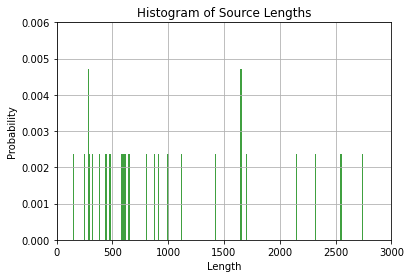

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(dataset.source_lengths, 1000, density=True, facecolor='g', alpha=0.75)

plt.xlabel('Length')
plt.ylabel('Probability')
plt.title('Histogram of Source Lengths')
plt.xlim(0, 3000)
plt.ylim(0, 0.006)
plt.grid(True)
plt.show()

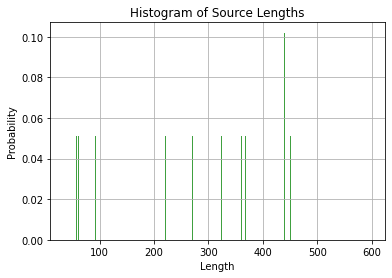

In [ ]:
n, bins, patches = plt.hist(dataset.target_lengths, 1000, density=True, facecolor='g', alpha=0.75)

plt.xlabel('Length')
plt.ylabel('Probability')
plt.title('Histogram of Source Lengths')
# plt.xlim(0, 3000)
# plt.ylim(0, 0.006)
plt.grid(True)
plt.show()

# **Finetuning Model**

In [34]:
torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [14]:
%%bash

cd "/content/drive/My Drive/CS196Project/Group6/finetuning/"
pwd

# Unused Alternative Parameters:
    # --do_predict \
    # --eval_batch_size=1 \

    # --freeze_embeds \
    # --fp16 \
    #     --max_target_length=60 \
    # --val_max_target_length=60 \
    # --test_max_target_length=100 \

# --val_metric, type=str, default=None, required=False, choices=["bleu", "rouge2", "loss", None]

# MODEL="google/pegasus-xsum"

export OUTPUT_DIR="t5-base-cnn"
export DATA_DIR="lecture_transcripts"

python seq2seq/finetune.py \
    --learning_rate=3e-5 \
    --gpus 1 \
    --do_train \
    --do_predict \
    --n_val 1000 \
    --val_check_interval 0.1 \
    --data_dir=$DATA_DIR \
    --train_batch_size=1 \
    --eval_batch_size=1 \
    --output_dir=$OUTPUT_DIR \
    --overwrite_output_dir \
    --freeze_encoder \
    --num_train_epochs 6 \
    --model_name_or_path "sshleifer/t5-small"
    "$@"

/content/drive/My Drive/CS196Project/Group6/finetuning


2020-11-05 06:33:07.046356: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/transformers/configuration_utils.py", line 373, in get_config_dict
    raise EnvironmentError
OSError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "seq2seq/finetune.py", line 442, in <module>
    main(args)
  File "seq2seq/finetune.py", line 381, in main
    model: SummarizationModule = SummarizationModule(args)
  File "seq2seq/finetune.py", line 65, in __init__
    super().__init__(hparams, num_labels=None, mode=self.mode, **kwargs)
  File "/content/drive/My Drive/CS196Project/Group6/finetuning/seq2seq/lightning_base.py", line 87, in __init__
    **config_kwargs,
  File "/usr/local/lib/python3.6/dist-packages/transformers/configuration_auto.py", line 330, in from_pretrained
    config_dict, _ = 

In [ ]:
%%bash
cd "/content/drive/My Drive/CS196Project/Group6/finetuning/"

python seq2seq/finetune.py --help

# **Test Model**

Showing that the fine-tuning has an effect: 

1.   Summarization with stored fine-tuned model
2.   Summarization with default model used



In [ ]:
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer, pipeline

%cd "/content/drive/My Drive/CS196Project/Group6/finetuning/"

device = 'cpu'
text = "DNA evidence has transformed forensic science and the criminal justice system. But what are the limits of using DNA as a tool in forensic science? To address this question we need to learn the basic structure of DNA and the rules of inheritance. Let’s start by simply defining a few terms, and we’ll start with the term heredity. Heredity can simply be defined as the passing of traits to offspring. We can think about this in 2 time scales—a short time scale over just 1 generation or a long time scale involving ancestors that go back millennia. Another term that we should define is phenotype. A measurable trait of an organism is often referred to as a phenotype. Here we list examples under different categories like disease or behavioral phenotypes. We can classify phenotypes into 2 types of traits: simple inherited traits and complex inherited traits.Traits of simple inheritance have the following characteristics: They are monogenic or controlled by only 1 gene. They are binary or discontinuous. And the expression of these traits is not greatly influenced by the environment. Simple inherited traits represent only a small fraction of all human traits."


# 1. Summarization with example fine-tuned model 
# model = AutoModelForSeq2SeqLM.from_pretrained(f'example_output/best_tfmr')
# tokenizer = AutoTokenizer.from_pretrained(f'example_output/best_tfmr')
# model = model.to(device)
# summarizer = pipeline('summarization', model=model, tokenizer=tokenizer)
# print(summarizer(text))

# 1.1 Summarization with finetuned distilbart-xsum-12-6
model = AutoModelForSeq2SeqLM.from_pretrained(f'distilbart-xsum-12-6/best_tfmr')
tokenizer = AutoTokenizer.from_pretrained(f'distilbart-xsum-12-6/best_tfmr')
model = model.to(device)
summarizer = pipeline('summarization', model=model, tokenizer=tokenizer)
print(summarizer(text))

# 1.2 Summarization with finetuned distilbart-cnn-12-6
model = AutoModelForSeq2SeqLM.from_pretrained(f'distilbart-cnn-12-6/best_tfmr')
tokenizer = AutoTokenizer.from_pretrained(f'distilbart-cnn-12-6/best_tfmr')
model = model.to(device)
summarizer = pipeline('summarization', model=model, tokenizer=tokenizer)
print(summarizer(text))

# 2. Summarization with default model used before finetuning
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6") 
model.to(device)
summarizer = pipeline('summarization', model=model, tokenizer=tokenizer)
print(summarizer(text))

/content/drive/My Drive/CS196Project/Group6/finetuning
[{'summary_text': ' The use of DNA as a tool in forensic science has been hailed as a game-changer.'}]
[{'summary_text': ' DNA evidence has transformed forensic science and the criminal justice system. But what are the limits of using DNA as a tool in forensic science? To address this question we need to learn the basic structure of DNA and the rules of inheritance. Let’s start by simply defining a few terms, and we’ll start with the term heredity.'}]
[{'summary_text': ' DNA evidence has transformed forensic science and the criminal justice system . But what are the limits of using DNA as a tool in forensic science? To address this question we need to learn the structure of DNA and the rules of inheritance . We can classify phenotypes into 2 types of traits: simple inherited traits and complex inherited traits . Simple inherited traits represent only a small fraction of all human traits .'}]
